## **importing libraries**

In [ ]:
import random 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import backend as K 

import cv2 
from tqdm import tqdm_notebook, tnrange 
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images 
from skimage.transform import resize 
from skimage.morphology import label 
from sklearn.model_selection import train_test_split 
from IPython.display import Image, display 

from skimage.color import rgb2gray

import tensorflow as tf 
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.models import Model, load_model, save_model 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint 
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPool2D, concatenate

c:\Users\ELNOOR\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\ELNOOR\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\ELNOOR\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


## **GLOBAL CONSTANTS**

In [2]:
im_width = 256
im_height = 256
random_state = 42
unet_architecture = 'Unet_Architecture.png'
epochs = 150
batch_size = 32
learning_rate = 1e-4

## **importing dataset**

In [3]:
mask_files = glob(pathname='archive/lgg-mri-segmentation/kaggle_3m/*/*_mask*')
image_filename_train = [i.replace('_mask', '') for i in mask_files]

In [4]:
print(image_filename_train[0])
print(mask_files[0])

archive/lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_10.tif
archive/lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_10_mask.tif


In [5]:
print(f'Features Shape: {cv2.imread(image_filename_train[0]).shape}')
print(f'Label Shape: {cv2.imread(mask_files[0]).shape}')

Features Shape: (256, 256, 3)
Label Shape: (256, 256, 3)


## **ploting images and masks**

In [6]:
def plot_from_image_path(nrows, ncols, image_filename_train, mask_files):
    fig = plt.figure(figsize=(12, 12))

    for i in range(1, nrows * ncols + 1):
        fig.add_subplot(nrows, ncols, i)

        img_path = image_filename_train[i]
        mask_path = mask_files[i]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path)

        plt.imshow(image)
        plt.imshow(mask, alpha=0.4, cmap='jet')
    
    plt.show()

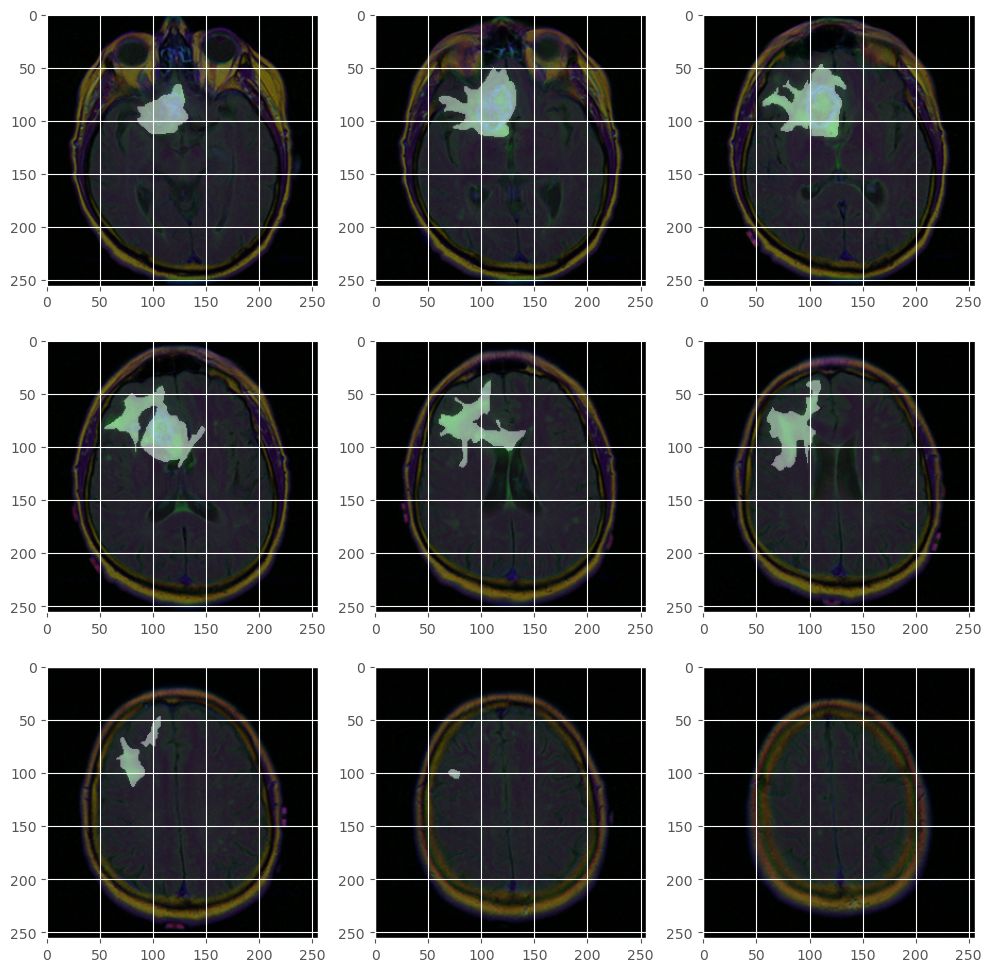

In [7]:
plot_from_image_path(3, 3, image_filename_train, mask_files)

## **preprocessing the data**

In [8]:
df = pd.DataFrame({'image_filename_train' : image_filename_train, 'mask' : mask_files})
df.head()

,image_filename_train,mask
0,archive/lgg-mri-segmentation/kaggle_3m\TCGA_CS...,archive/lgg-mri-segmentation/kaggle_3m\TCGA_CS...
1,archive/lgg-mri-segmentation/kaggle_3m\TCGA_CS...,archive/lgg-mri-segmentation/kaggle_3m\TCGA_CS...
2,archive/lgg-mri-segmentation/kaggle_3m\TCGA_CS...,archive/lgg-mri-segmentation/kaggle_3m\TCGA_CS...
3,archive/lgg-mri-segmentation/kaggle_3m\TCGA_CS...,archive/lgg-mri-segmentation/kaggle_3m\TCGA_CS...
4,archive/lgg-mri-segmentation/kaggle_3m\TCGA_CS...,archive/lgg-mri-segmentation/kaggle_3m\TCGA_CS...


In [9]:
df_train, df_test = train_test_split(df, test_size=0.05, random_state=random_state)
df_train, df_val = train_test_split(df_train, test_size=0.05, random_state=random_state)

In [10]:
print(f'Training Data: {df_train.shape}')
print(f'Testing Data: {df_test.shape}')
print(f'Validation Data: {df_val.shape}')

Training Data: (3545, 2)
Testing Data: (197, 2)
Validation Data: (187, 2)


In [11]:
def check_dataset_balancing(labels):
    tumor, non_tumor = 0, 0

    for i in labels:
        mask = cv2.imread(i)
        if np.any(mask > 0):
            tumor += 1
        else:
            non_tumor += 1
    
    return tumor, non_tumor

In [12]:
tumor, non_tumor = check_dataset_balancing(mask_files)

In [13]:
def bar_plot(categories, counts, title, colors=['red', 'blue'], xlabel = '', ylabel = ''):
    plt.figure()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.bar(categories, counts, color=colors)
    plt.show()

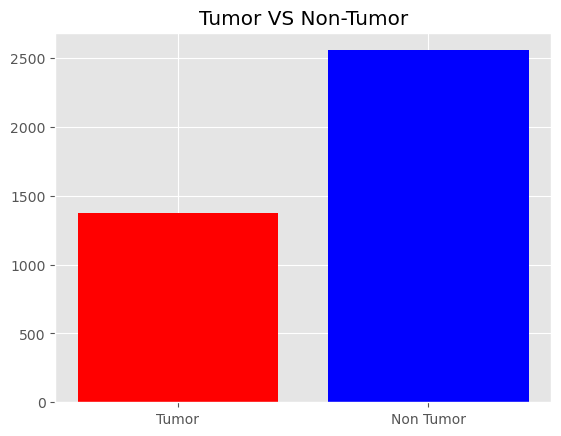

In [14]:
bar_plot(categories=['Tumor', 'Non Tumor'], counts=[tumor, non_tumor], title='Tumor VS Non-Tumor', colors=['red', 'blue'])

In [15]:
def normalize_and_diagnose(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img, mask)

In [ ]:
def train_generator(data_frame, 
                    batch_size, 
                    augmentation_dict, 
                    image_color_mode='rgb', 
                    mask_color_mode='grayscale',
                    image_save_prefix='image', 
                    mask_save_prefix='mask', 
                    save_to_dir=None, 
                    target_size=(256, 256, 3), 
                    seed=random_state):
    
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)
    
    image_generator = image_datagen.flow_from_dataframe(data_frame, 
                                                        x_col='image_filename_train', 
                                                        class_mode=None, 
                                                        color_mode=image_color_mode, 
                                                        target_size=target_size, 
                                                        batch_size=batch_size,
                                                        save_to_dir=save_to_dir, 
                                                        save_prefix=image_save_prefix, 
                                                        seed=seed)
    
    mask_generator = mask_datagen.flow_from_dataframe(data_frame, 
                                                      x_col='mask', 
                                                      class_mode=None,
                                                      color_mode=mask_color_mode,
                                                      target_size=target_size,
                                                      batch_size=batch_size,
                                                      save_to_dir=save_to_dir,
                                                      save_prefix=mask_save_prefix,
                                                      seed=seed)
    
    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
    
        yield (img, mask)

## **Define Loss Functions and Metrics Functions**

In [17]:
def dice_coefficients(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)

    return (2 * intersection + smooth) / (union + smooth)

In [18]:
def dice_coefficients_loss(y_true, y_pred, smooth=100):
    return -dice_coefficients(y_true, y_pred, smooth)

In [19]:
def iou(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)

    return iou

In [20]:
def jaccard_distance(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    return -iou(y_true_flatten, y_pred_flatten)

## **UNet Architecture**

In [21]:
def plot_unet_architecture(filepath):
    return display(Image(filename=filepath))

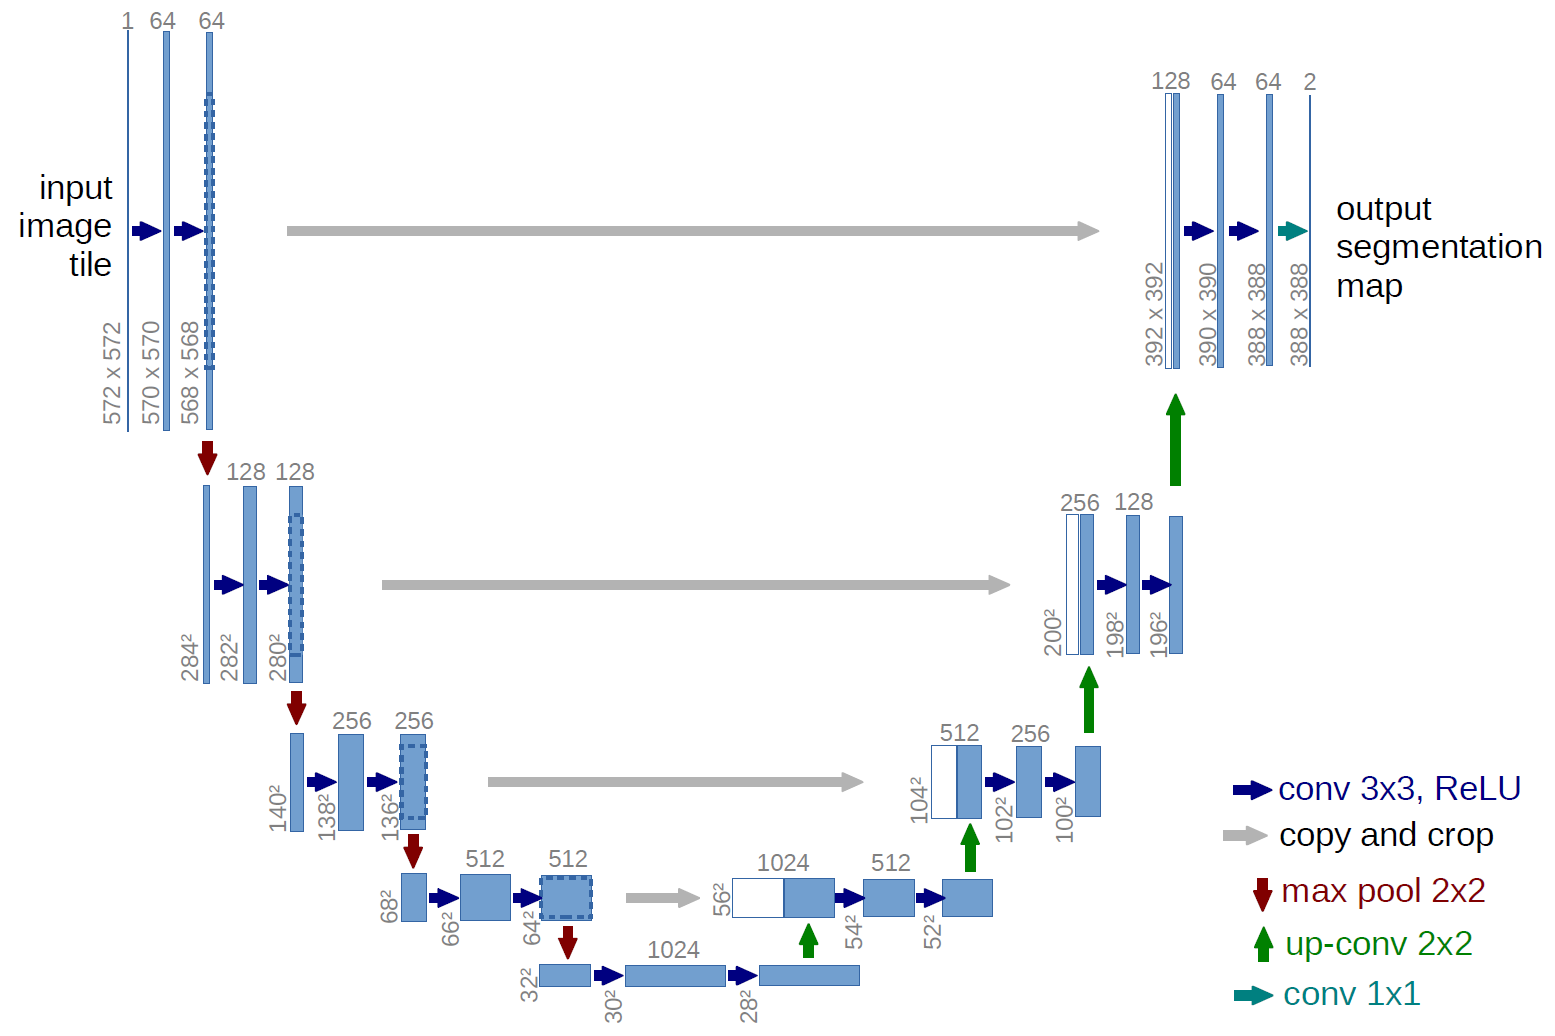

In [22]:
plot_unet_architecture('Unet_Architecture.png')

In [ ]:
def unet(input_size=(im_height, im_width, 3)):
    #Input layer
    inputs = Input(shape=input_size)

    #Encoder(downsampling)
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPool2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPool2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPool2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPool2D(pool_size=(2, 2))(conv4)

    #Bottleneck
    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), activation='relu', padding='same')(conv5)

    #Decoder(upsampling)
    up6 = concatenate([Conv2DTranspose(filters=512, kernel_size=(2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(filters=256, kernel_size=(2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(conv9)

    #Output layer
    conv10 = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

## **creating augmentation arguments**

In [24]:
train_generator_args = dict(
    rotation_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [25]:
train_gen = train_generator(df_train, 
                            batch_size,
                            train_generator_args,
                            target_size=(im_height, im_width))

val_gen = train_generator(df_val, 
                            batch_size,
                            dict(),
                            target_size=(im_height, im_width))

## **Define hyperparameters**

In [26]:
x_batch, y_batch = next(train_gen)
print(f"x_batch shape: {x_batch.shape}, y_batch shape: {y_batch.shape}")


Found 3545 validated image filenames.
Found 3545 validated image filenames.
x_batch shape: (32, 256, 256, 3), y_batch shape: (32, 256, 256, 1)


In [27]:
optimizer = Adam(learning_rate=learning_rate, 
                 beta_1=0.9, 
                 beta_2=0.999, 
                 epsilon=None, 
                 amsgrad=False)

In [28]:
model = unet(input_size=(im_height, im_width, 3))

In [29]:
print(model.input_shape)

(None, 256, 256, 3)


In [30]:
x_batch, y_batch = next(train_gen)
x_batch = tf.convert_to_tensor(x_batch, dtype=tf.float32)
y_batch = tf.convert_to_tensor(y_batch, dtype=tf.float32)

print(x_batch.shape, y_batch.shape)

(32, 256, 256, 3) (32, 256, 256, 1)


In [31]:
model.compile(optimizer=optimizer, 
              loss=dice_coefficients_loss, 
              metrics=['binary_accuracy', iou, dice_coefficients],
              run_eagerly=True)

In [32]:
callbacks = [ModelCheckpoint('unet_brain_mri_seg.keras', 
                             verbose=1, 
                             save_best_only=True)]

## **Training the model**

In [33]:
history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) // batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=val_gen,
                    validation_steps=len(df_val) // batch_size)

Epoch 1/150


c:\Users\ELNOOR\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1CLONE']
Received: inputs=Tensor(shape=(32, 256, 256, 3))
  warnings.warn(msg)


ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.